In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)

k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

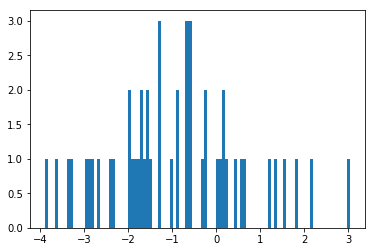

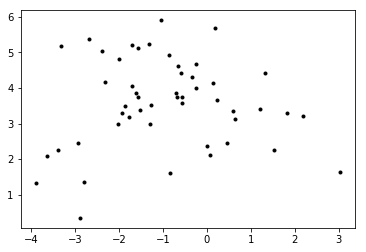

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 48.964852986009824
Step 10 objective: 0.1235802394749328
Step 20 objective: 0.6468035461143451
Step 30 objective: 0.832791297220778
Step 40 objective: 0.005511545126962503
Step 50 objective: 0.000825853996033743
Step 60 objective: 4.7466979717469826e-05
Step 70 objective: 2.3887873297212536e-06
Done with CAVI.


In [7]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print(np.all(np.isfinite(cavi_params)))

True


In [8]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
tr_params = deepcopy(vb_opt.x)
tr_tau, tr_phi_mu, tr_phi_var, tr_nu = data_set.unpack_params(tr_params)


Step 0 objective: -345.16392764507583
Optimization terminated successfully.
         Current function value: -345.163928
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done with Newton trust region.


In [10]:
print ('CAVI:')
print (cavi_phi_mu.transpose())

print ('Full TR:')
tau, phi_mu, phi_var, nu = data_set.unpack_params(tr_params)
print (phi_mu.transpose())

print ('Truth:')
print (A)

CAVI:
[[-1.18004894  4.12360917]
 [ 2.13079957 -1.08590817]
 [-1.90613516 -2.27309642]]
Full TR:
[[-1.18004894  4.12360908]
 [ 2.13080066 -1.08590909]
 [-1.90613424 -2.27309633]]
Truth:
[[-2.60019209  1.78137362]
 [ 1.77736326  2.28397343]
 [-0.08857654  0.2192766 ]]


Cavi residuals: 60.555251128787766    Trust residuals: 60.555250232916315      True residuals: 81.85276606722681


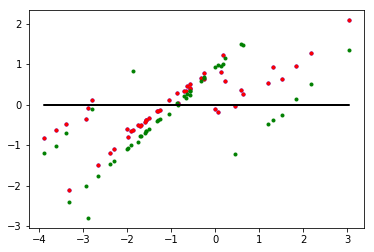

In [11]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(tr_params)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [13]:
def get_moments(params, data_set):
    # Return moments of interest.
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params)
    e_log_pi, e_log_pi2, e_mu, phi_moment2, nu_moment = \
        vi.get_moments(tau, nu, phi_mu, phi_var)
    return e_log_pi, e_mu

def get_moments_vector(params, data_set):
    e_log_pi, e_mu = get_moments(params, data_set)
    return packing.pack_moments(e_log_pi, e_mu)

get_moments_vector_jac = jacobian(get_moments_vector)

jac_time = time.time()
moment_jac = get_moments_vector_jac(tr_params, data_set)
jac_time = time.time() - jac_time
print (jac_time)

par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(tr_params, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time


0.004901885986328125


In [14]:
hess_time = time.time()
kl_hess = data_set.get_kl_hessian(tr_params)
hess_time = time.time() - hess_time
kl_hess_eigvals = np.linalg.eigvals(kl_hess)
print (hess_time)

0.9084982872009277


In [16]:
print (np.max(kl_hess_eigvals))
print (np.min(kl_hess_eigvals))

54.2614057426
1.03513410166e-08


In [17]:
# Eq. 18 from our paper.  The -1 comes from the fact that par_hp_hess is of the
# KL divergence, not the expected log probability.
sensitivity_operator = -1 * np.linalg.solve(kl_hess, par_hp_hess.T)
moment_sensitivity = np.matmul(moment_jac, sensitivity_operator)

print(moment_sensitivity)

[[  1.12501005e-04   1.86003668e-06  -2.56665507e-04]
 [  4.09855740e-02  -6.03339415e-04  -2.87894062e-01]
 [  3.91682596e-02  -1.23243371e-03  -1.53586159e-01]
 [ -8.63911960e-03  -5.55461015e-04   2.22115044e-01]
 [ -1.68700183e-02   3.88891239e-03  -4.00999007e-01]
 [  1.10218781e-02  -5.31873387e-03  -4.98326998e-02]
 [  8.47996973e-03   2.59973728e-03  -2.87594896e-01]
 [  8.48716794e-03  -4.97309285e-03   3.34899443e-01]
 [  1.04937411e-02  -8.77489014e-03   3.49006424e-01]]


In [18]:
# The third column is sigma_eps.

sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

Sensitivity of e_log_pi to sigma_eps:
[ -2.56665507e-04  -2.87894062e-01  -1.53586159e-01]
Sensitivity of e_mu to sigma_eps:
[[ 0.22211504 -0.40099901 -0.0498327 ]
 [-0.2875949   0.33489944  0.34900642]]


In [19]:
# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)

Step 0 objective: -309.3501580396163
Step 1 objective: -309.4286344030809
Step 2 objective: -309.4349710358883
Step 3 objective: -309.4516077984229
Step 4 objective: -309.46078156650594
Step 5 objective: -309.4682510308509
Step 6 objective: -309.47102815463074
Step 7 objective: -309.4720458182407
Step 8 objective: -309.4724678487112
Step 9 objective: -309.47246791249415
Step 10 objective: -309.47259243782185
Step 11 objective: -309.4725932664295
Step 12 objective: -309.4726104855678
Step 13 objective: -309.47263159987915
Step 14 objective: -309.47262507740436
Step 15 objective: -309.4726371656764
Step 16 objective: -309.4726381633643
Step 17 objective: -309.4726395405158
Step 18 objective: -309.4726388606502
Step 19 objective: -309.4726399875748
Step 20 objective: -309.47263997088703
Step 21 objective: -309.4726400656866
Step 22 objective: -309.4726400732773
Optimization terminated successfully.
         Current function value: -309.472640
         Iterations: 22
         Function eval

In [20]:
e_log_pi, e_mu = get_moments(tr_params, data_set)
e_log_pi_perturb, e_mu_perturb = get_moments(vb_opt_perturb.x, data_set)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

Measured sensitivity of e_mu to sigma_eps:
[[ 0.21065073 -0.42696367 -0.03390204]
 [-0.28627406  0.37698007  0.3993301 ]]
Sensitivity of e_mu to sigma_eps:
[[ 0.22211504 -0.40099901 -0.0498327 ]
 [-0.2875949   0.33489944  0.34900642]]
Measured sensitivity of e_log_pi to sigma_eps:
[-0.00032035 -0.26459737 -0.1422972 ]
Sensitivity of e_log_pi to sigma_eps:
[ -2.56665507e-04  -2.87894062e-01  -1.53586159e-01]
